In [4]:
import numpy as np
import matplotlib.pyplot as plt
import io, urllib.request

This code downloads a picture (feel free to use your own):

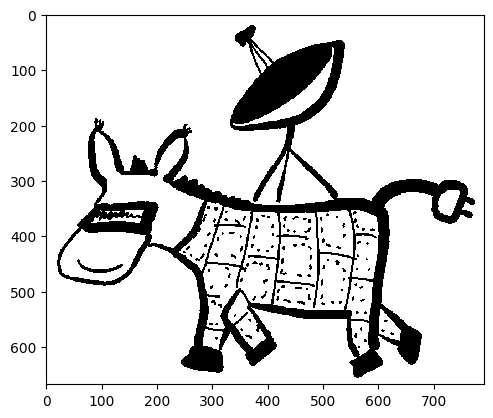

In [5]:
URL = "https://github.com/qi-rub/it-ss23-homework/raw/main/material/donkey.png"
ORIGINAL = plt.imread(io.BytesIO(urllib.request.urlopen(URL).read()))

# remove alpha channel
if ORIGINAL.shape[2] == 4:
    alpha = ORIGINAL[:, :, 3:]
    ORIGINAL = ORIGINAL[:, :, :3] * alpha + (1 - alpha)

# convert to black & white
WHITE_THRESHOLD = 0.8
ORIGINAL = np.where(ORIGINAL[:, :, :3].max(axis=2) > WHITE_THRESHOLD, 0, 1)

# show the figure
plt.imshow(ORIGINAL, cmap=plt.get_cmap("binary"), interpolation="none")
plt.show()

All inputs and outputs should be 2d arrays that contain only zeros and ones (corresponding to black&white images).
For example:

In [6]:
ORIGINAL.shape

(668, 791)

In [7]:
set(ORIGINAL.flatten())

{np.int64(0), np.int64(1)}

# The Noise Channel

The following function should model a noise channel with probability of bit flip $f$.
<span style="background-color: yellow">Right now it does nothing -- can you fix this?</span>

*Hint: Never modify an input parameter. If you really need to, make a copy (`output = input.copy()`) before you start modifying.*

In [19]:
def noise_channel(f, input):
  output = input.copy()

  # generate random flips with rate "f"
  flips = np.random.random(size=input.shape) < f

  # probability of no flips = 1 - f
  output[flips] = 1 - output[flips]

  return output


You can test your implementation with the following code:

In [20]:
NOISE_RATE = 0.1
output = noise_channel(NOISE_RATE, ORIGINAL)

f_est = np.mean(output != ORIGINAL)
print(f"{NOISE_RATE:3.0%} bit flips expected")
print(f"{f_est:3.0%} bit flips detected")

10% bit flips expected
10% bit flips detected


# The Repetition Code

The following two functions should implement the repetition code $R_3$.
<span style="background-color: yellow">Right now these functions do nothing at all either -- can you fix this?</span>

In [79]:
def encode(source):
  # add a new axis to make each pixel a 1-element vector: shape (H, W) -> (H, W, 1)
  source = source[:, :, np.newaxis]

  # repeat each bit 3 times along the new axis: shape (H, W, 1) -> (H, W, 3)
  # example: 0 -> [0, 0, 0], 1 -> [1, 1, 1]
  encoded = np.repeat(source, 3, axis=2)

  # flatten to restore 2D shape: (H, W, 3) -> (H, W*3)
  encoded = encoded.reshape(source.shape[0], source.shape[1] * 3)

  return encoded

def decode(received):
    # reshape the array so each triplet of bits corresponds to one original pixel:
    # shape (H, W*3) -> (H, W, 3)
    # example: [1, 0, 1, 0, 0, 0] -> [[1, 0, 1], [0, 0, 0]]
    reshaped = received.reshape(received.shape[0], received.shape[1] // 3, 3)

    # majority vote along last axis (axis=2) to decode each pixel:
    # sum the 3 bits in each triplet, if >=2 -> 1, else -> 0
    decoded = (np.sum(reshaped, axis=2) >= 2).astype(int)

    return decoded


You can test your solution with the following code:

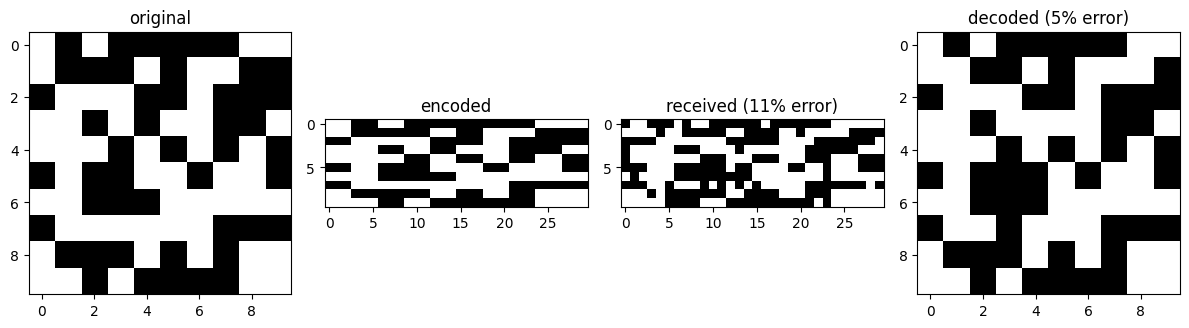

In [80]:
# simulate channel
encoded = encode(ORIGINAL)

received = noise_channel(NOISE_RATE, encoded)
assert received.shape == encoded.shape, "Noise channel should not change image size."

decoded = decode(received)
assert (
    decoded.shape == ORIGINAL.shape
), "Decoder should produce image of same size as the original."


# compute statistics
f_raw = np.mean(received != encoded)
f_dec = np.mean(decoded != ORIGINAL)

# plot pictures
fig, row = plt.subplots(1, 4, figsize=(12, 12))

row[0].set_title("original")
row[0].imshow(ORIGINAL, cmap=plt.get_cmap("binary"), interpolation="none")

row[1].set_title("encoded")
row[1].imshow(encoded, cmap=plt.get_cmap("binary"), interpolation="none")

row[2].set_title(f"received ({f_raw:.0%} error)")
row[2].imshow(received, cmap=plt.get_cmap("binary"), interpolation="none")

row[3].set_title(f"decoded ({f_dec:.0%} error)")
row[3].imshow(decoded, cmap=plt.get_cmap("binary"), interpolation="none")

fig.tight_layout()

Does the output look similar to Figure 1.11 in [MacKay's book](http://www.inference.org.uk/itprnn/book.pdf)?

**Bonus challenges (completely optional):**
1. Change your code to implement the repetition code $R_5$.
2. Change your code to implement the repetition code $R_k$ for general $k$. How does the error of the decoded image change as a function of $f$ and $k$?

In [82]:
# Bonus challenge question 1 (repetition code R5):

def encode_R5(source):
  # add a new axis to make each pixel a 1-element vector: shape (H, W) -> (H, W, 1)
  source = source[:, :, np.newaxis]

  # repeat each bit 3 times along the new axis: shape (H, W, 1) -> (H, W, 3)
  encoded = np.repeat(source, 5, axis=2)

  # flatten to restore 2D shape: (H, W, 5) -> (H, W*5)
  encoded = encoded.reshape(source.shape[0], source.shape[1] * 5)

  return encoded

def decode_R5(received):
    # reshape the array so each triplet of bits corresponds to one original pixel:
    # shape (H, W*5) -> (H, W, 5)
    reshaped = received.reshape(received.shape[0], received.shape[1] // 5, 5)

    # majority vote along last axis (axis=2) to decode each pixel:
    # sum the 5 bits in each triplet, if >=3 -> 1, else -> 0
    decoded = (np.sum(reshaped, axis=2) >= 3).astype(int)

    return decoded

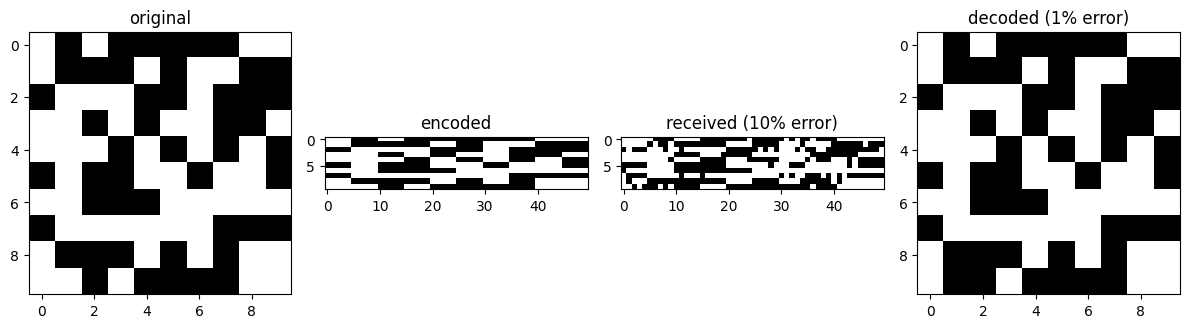

In [83]:
# check from R3 repurposed for the R5 code

# simulate channel
encode_R5 = encode_R5(ORIGINAL)

received = noise_channel(NOISE_RATE, encode_R5)
assert received.shape == encode_R5.shape, "Noise channel should not change image size."

decode_R5 = decode_R5(received)
assert (
    decode_R5.shape == ORIGINAL.shape
), "Decoder should produce image of same size as the original."


# compute statistics
f_raw = np.mean(received != encode_R5)
f_dec = np.mean(decode_R5 != ORIGINAL)

# plot pictures
fig, row = plt.subplots(1, 4, figsize=(12, 12))

row[0].set_title("original")
row[0].imshow(ORIGINAL, cmap=plt.get_cmap("binary"), interpolation="none")

row[1].set_title("encoded")
row[1].imshow(encode_R5, cmap=plt.get_cmap("binary"), interpolation="none")

row[2].set_title(f"received ({f_raw:.0%} error)")
row[2].imshow(received, cmap=plt.get_cmap("binary"), interpolation="none")

row[3].set_title(f"decoded ({f_dec:.0%} error)")
row[3].imshow(decode_R5, cmap=plt.get_cmap("binary"), interpolation="none")

fig.tight_layout()